# Ensemble: evspsl

## Imports & defaults

In [1]:
import libs.analysis
import libs.ensemble
import libs.local
import libs.plot
import libs.vars
import matplotlib
import matplotlib.pyplot as plt
import xarray

matplotlib.rcParams.update({ 'font.size': 18 })

/home/users/woodward/.conda/envs/climate/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


## Data

In [2]:
# ----- SPECIFIC SETTINGS -----
component = 'Amon'
experiment = 'ssp585'
variable_id = 'evspsbl'

conf = [v for v in libs.vars.variables() if v['variable_id'] == variable_id][0]
#time_series_text = conf['text']
time_series_weighted_method = conf['weighting_method']
time_series_units = conf['units']
time_series_y_label = f'Evaporation ({time_series_units})'
time_series_y_range = (0, 1.5)
time_series_y_range_full = (0, 2.5)
time_series_y_range_monthly = (0, 2)
time_series_y_range_regional = (0, 4)
time_series_process = lambda x: x

time_series_text = '''evaporation and sublimation over sea ice and ocean (solid),
sea ice (dashed), melt pond on sea ice (dashdot)'''

In [3]:
ensemble, weight = libs.ensemble.get_and_preprocess(
    component, 
    experiment, 
    variable_id,
    preprocess=conf['preprocess']
)

ensemble_time_series = time_series_process(
    libs.local.get_ensemble_series(variable_id, experiment)
)

time_slices = libs.vars.default_time_slices()
ensemble_time_slices = libs.analysis.generate_slices(ensemble)

In [4]:
ensemble_simpconc, weight_simpconc = libs.ensemble.get_and_preprocess(
    'SImon', 
    experiment, 
    'simpconc'
)

data_vars_simpconc = {}
for item in ensemble:
    item_mask = [item_mask for item_mask in ensemble_simpconc if item_mask['label'] == item['label']]
    if len(item_mask) == 0:
        continue
        
    item_mask = item_mask[0]['data']
    processed_data = time_series_process(item['data'])
    processed_data.attrs['color'] = item['color']
    processed_data = processed_data.drop_vars(['height', 'type'], errors='ignore')
    item_mask = item_mask.drop_vars(['height', 'type'], errors='ignore')
    
    item_weighted = (processed_data * item_mask / 100).weighted(weight)
    item_reduced = getattr(
        item_weighted, 
        time_series_weighted_method
    )(dim=item_weighted.weights.dims, skipna=True)
    item_reduced.attrs['plot_kwargs'] = { 'linestyle': 'dashdot' }
    
    data_vars_simpconc[item['label']] = item_reduced

ds_simpconc = xarray.Dataset(data_vars=data_vars_simpconc)
ds_simpconc = libs.ensemble.calc_variable_mean(ds_simpconc)
ds_simpconc['Ensemble mean'].attrs['plot_kwargs'] = { 'linestyle': 'dashdot' }

Error 404
-> _data/cmip6/CanESM5/simpconc/simpconc_SImon_CanESM5_ssp585_r1i1p2f1_gn_201501-210012_processed.nc
Error 404
-> _data/cmip6/EC-Earth3/simpconc/simpconc_SImon_EC-Earth3_ssp585_r4i1p1f1_gn_201501-210012_processed.nc
Error 404
-> _data/cmip6/IPSL-CM6A-LR/simpconc/simpconc_SImon_IPSL-CM6A-LR_ssp585_r1i1p1f1_gn_201501-210012_processed.nc
Error 404
-> _data/cmip6/MIROC6/simpconc/simpconc_SImon_MIROC6_ssp585_r1i1p1f1_gn_201501-210012_processed.nc
Error 404
-> _data/cmip6/MPI-ESM1-2-LR/simpconc/simpconc_SImon_MPI-ESM1-2-LR_ssp585_r1i1p1f1_gn_201501-210012_processed.nc
Error 404
-> _data/cmip6/MRI-ESM2-0/simpconc/simpconc_SImon_MRI-ESM2-0_ssp585_r1i1p1f1_gn_201501-210012_processed.nc


In [5]:
ensemble_siconc, weight_siconc = libs.ensemble.get_and_preprocess(
    'SImon', 
    experiment, 
    'siconc'
)

data_vars = {}
for item in ensemble:
    item_mask = [item_mask for item_mask in ensemble_siconc if item_mask['label'] == item['label']]
    if len(item_mask) == 0:
        continue
        
    item_mask = item_mask[0]['data']
    processed_data = time_series_process(item['data'])
    processed_data.attrs['color'] = item['color']
    processed_data = processed_data.drop_vars(['height', 'type'], errors='ignore')
    item_mask = item_mask.drop_vars(['height', 'type'], errors='ignore')
    
    #item_weighted = (processed_data * item_mask / 100).weighted(weight)
    item_weighted = processed_data.where(item_mask > 0).weighted(weight)
    item_reduced = getattr(
        item_weighted, 
        time_series_weighted_method
    )(dim=item_weighted.weights.dims, skipna=True)
    item_reduced.attrs['plot_kwargs'] = { 'linestyle': 'dashed' }
    
    data_vars[item['label']] = item_reduced

ds_si = xarray.Dataset(data_vars=data_vars)
ds_si = libs.ensemble.calc_variable_mean(ds_si)
ds_si['Ensemble mean'].attrs['plot_kwargs'] = { 'linestyle': 'dashed' }

## Time series

### Mean

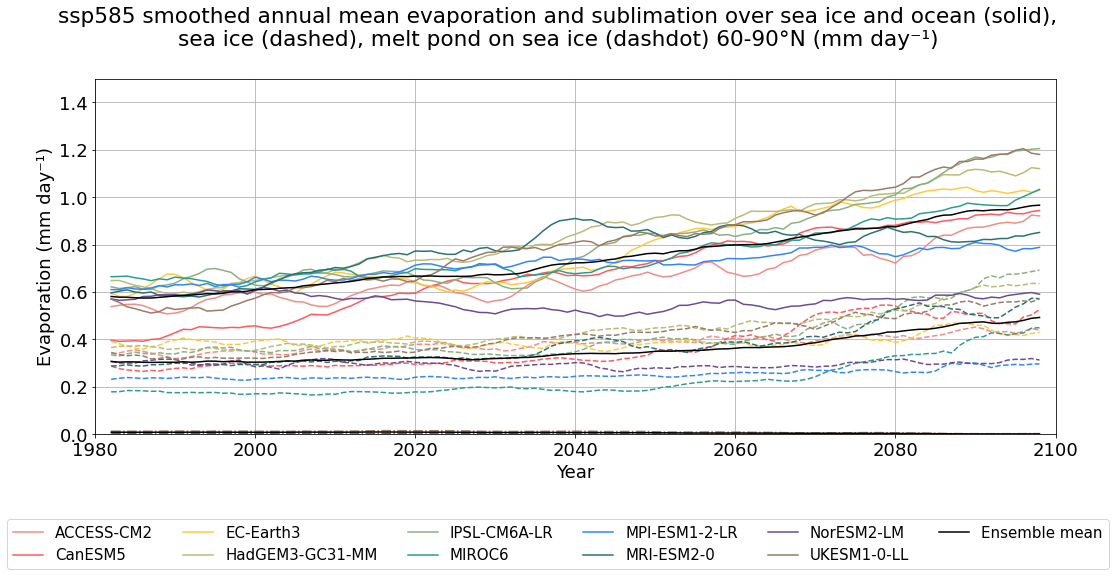

In [6]:
vars_series = [
    ensemble_time_series,
    ds_si,
    ds_simpconc
]
plot_arr = []
for item in vars_series:
    item_processed = item.groupby('time.year').mean('time').rolling(year=5, center=True).mean('year')
    item_processed = libs.ensemble.calc_variable_mean(item_processed)
    plot_arr.append(item_processed)


libs.plot.time_series_from_vars(
    plot_arr,
    title=f'{experiment} smoothed annual mean {time_series_text} 60-90°N ({time_series_units})',
    xattr='year',
    ylabel=time_series_y_label,
    yrange=time_series_y_range
);

### Full variability

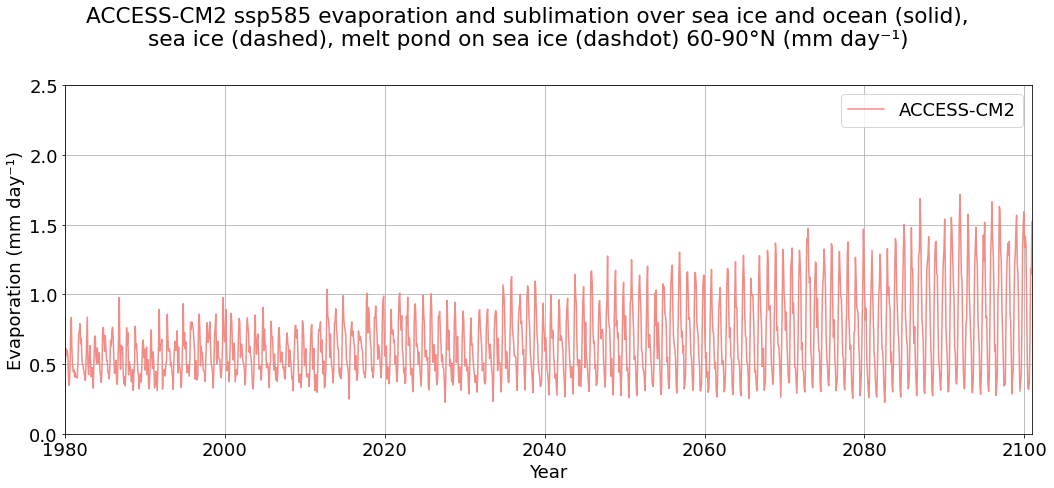

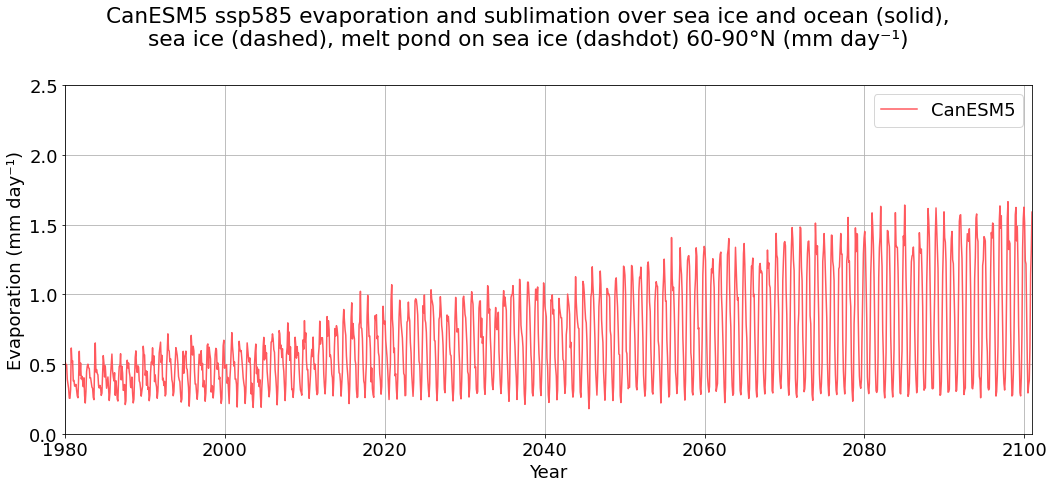

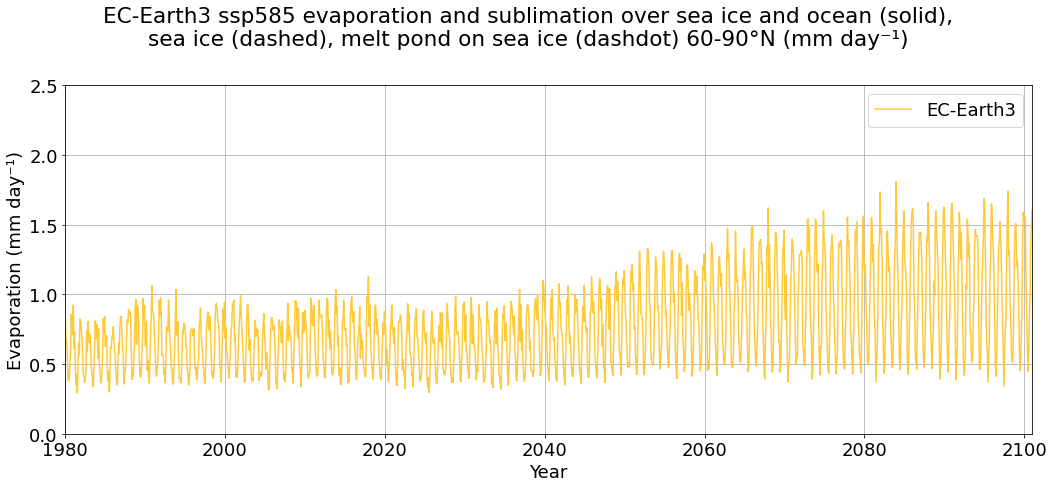

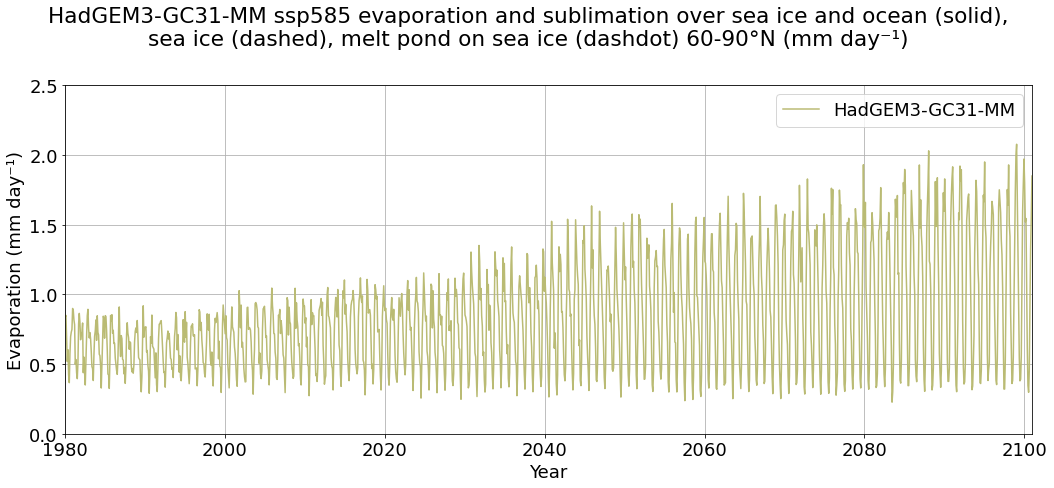

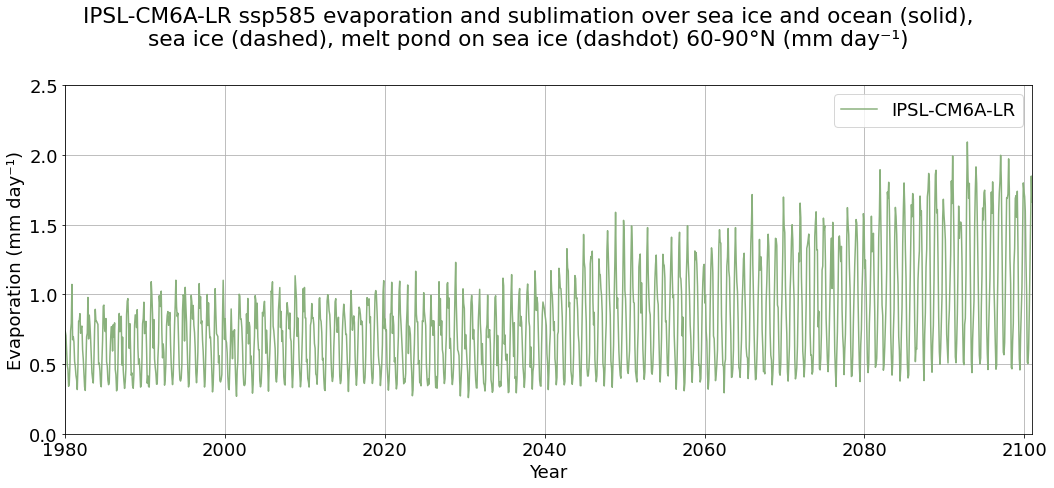

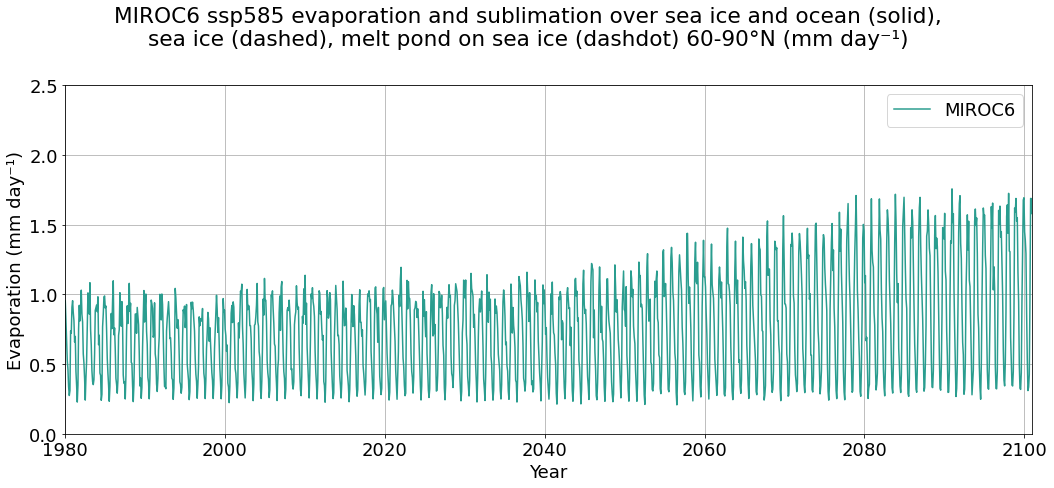

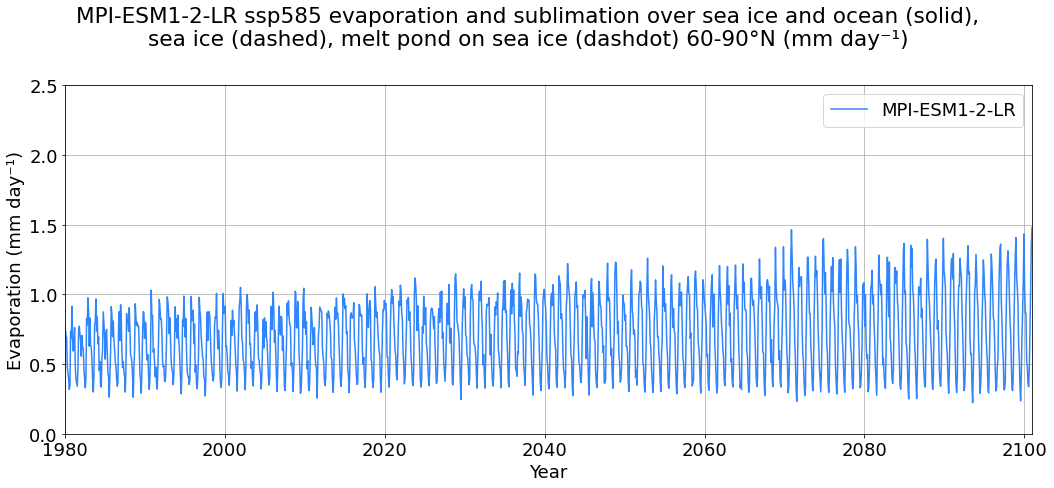

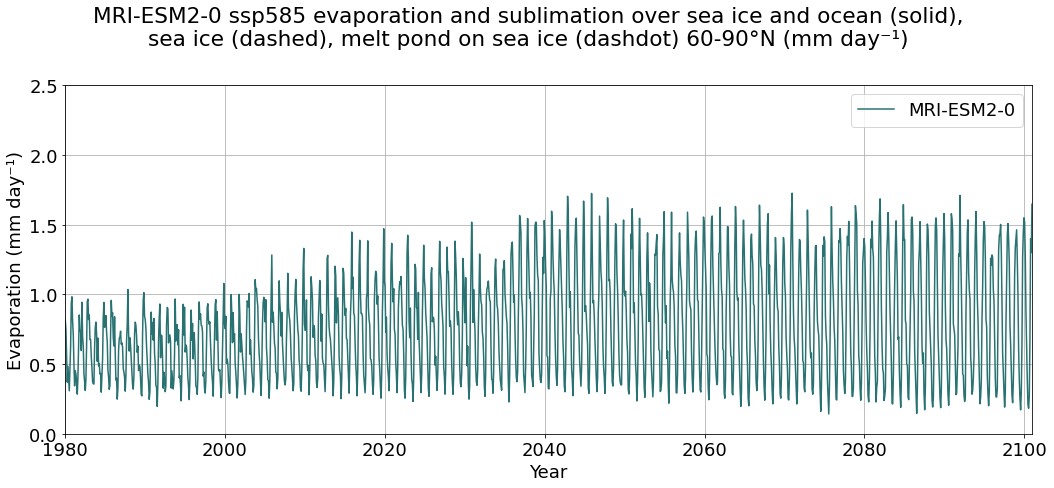

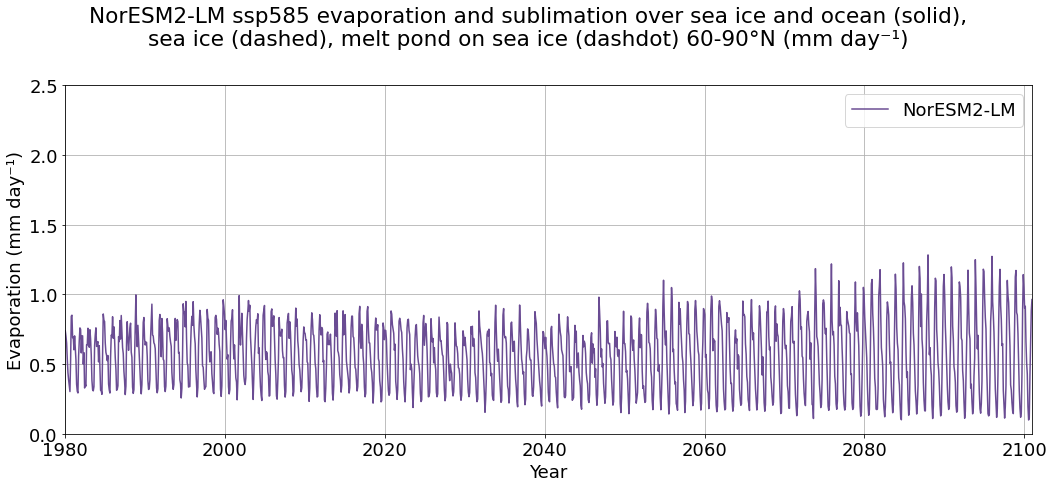

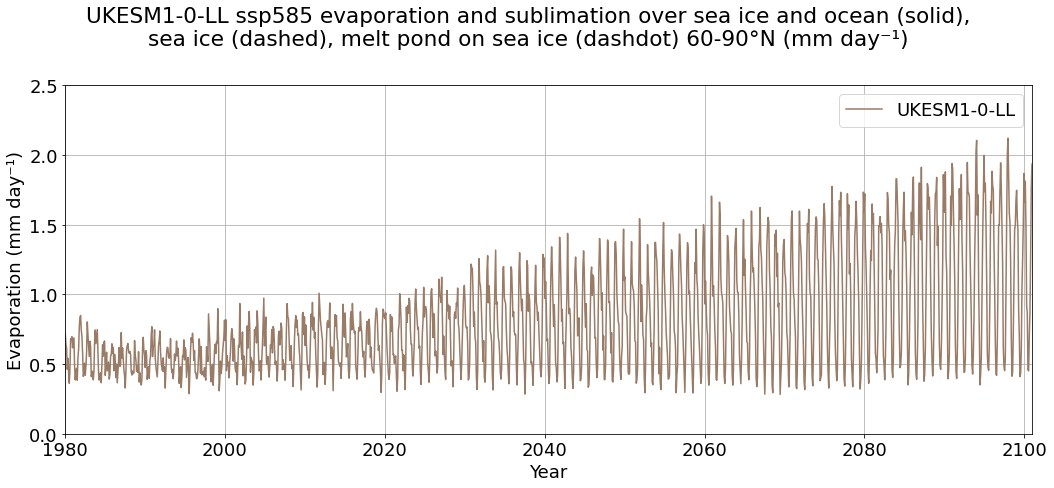

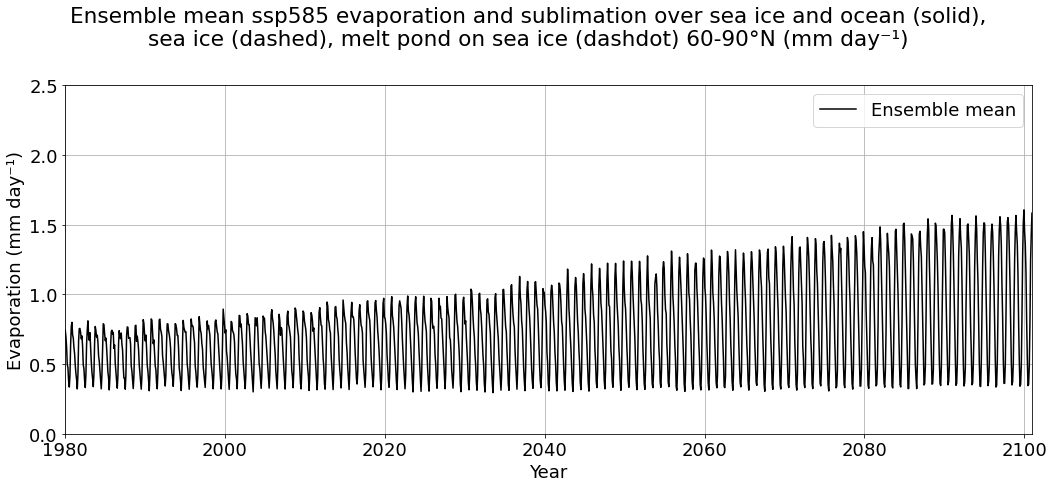

In [7]:
libs.ensemble.time_series_full_variability(
    ensemble_time_series,
    plot_kwargs={
        'title': f'{{member}} {experiment} {time_series_text} 60-90°N ({time_series_units})',
        'ylabel': time_series_y_label,
        'yrange': time_series_y_range_full
    }
)

## Monthly variability

### Full region (time)

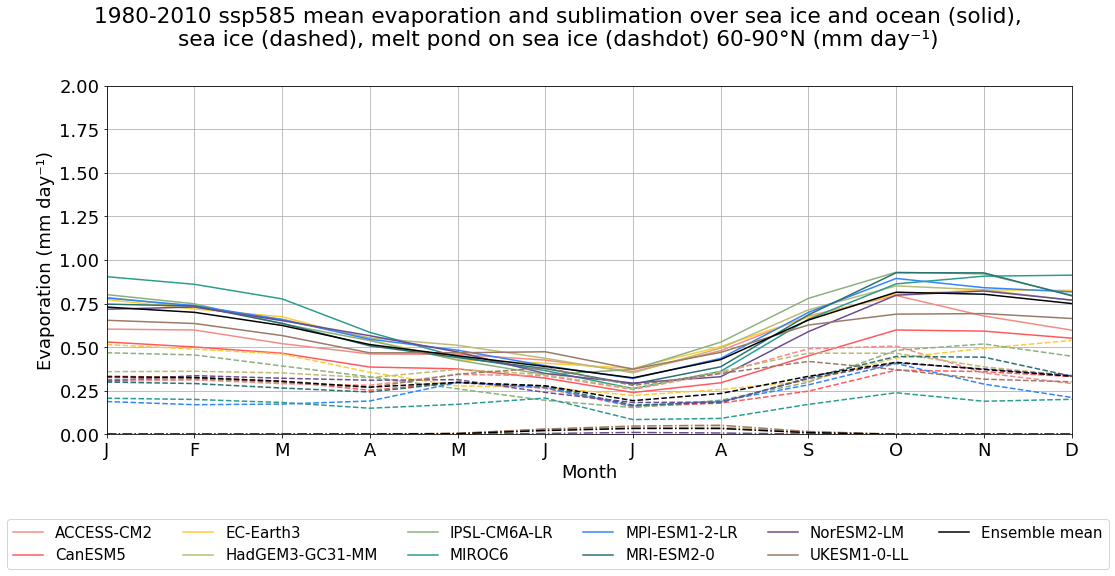

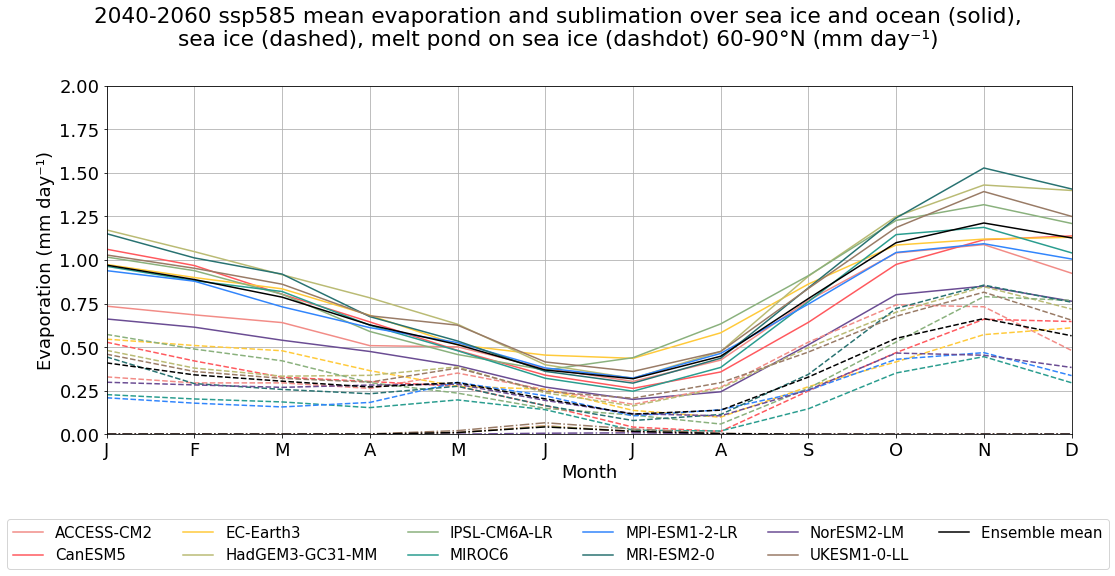

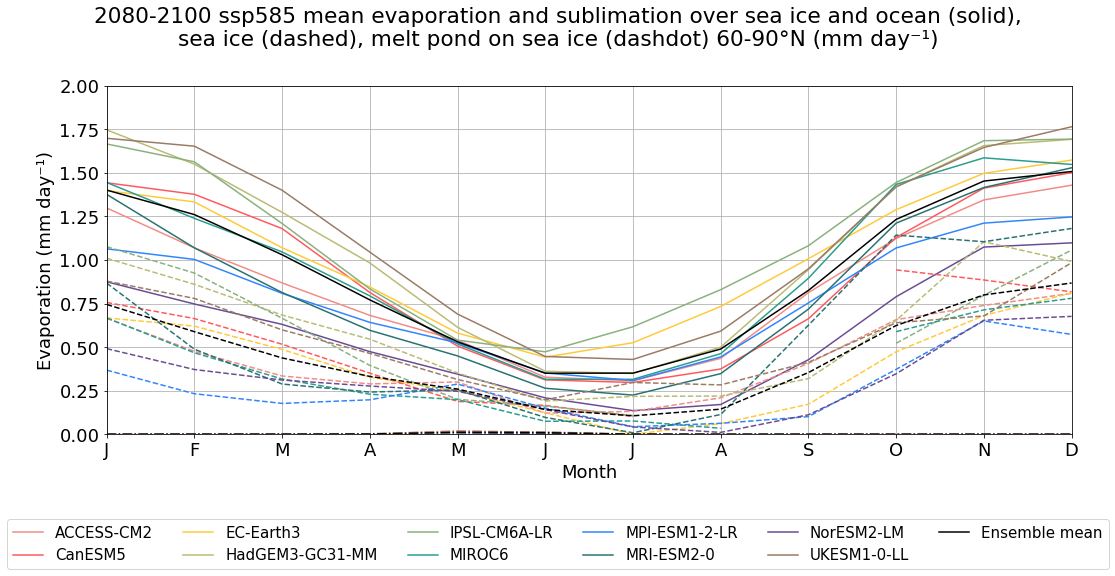

In [10]:
for s in time_slices:
    s_label = s['label']

    libs.plot.monthly_variability(
        [
            ensemble_time_series.sel(**s['slice']).groupby('time.month').mean('time'),
            ds_si.sel(**s['slice']).groupby('time.month').mean('time'),
            ds_simpconc.sel(**s['slice']).groupby('time.month').mean('time'),
        ],
        title=f'{s_label} {experiment} mean {time_series_text} 60-90°N ({time_series_units})',
        ylabel=time_series_y_label,
        yrange=time_series_y_range_monthly
    )

### E/P Regional Ratio

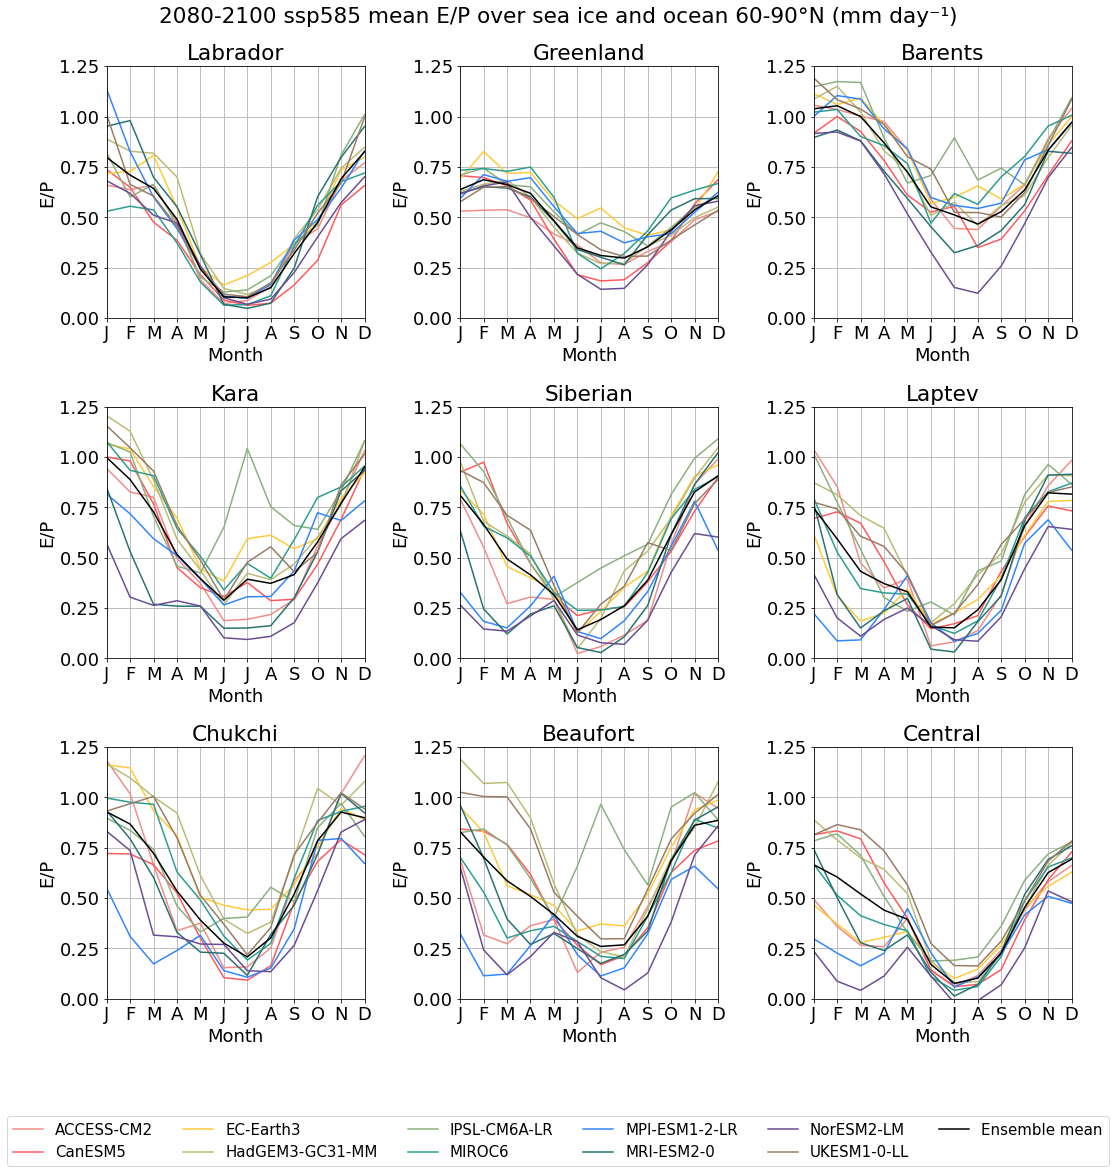

In [11]:
regions_evspsbl = libs.local.get_ensemble_regional_series('evspsbl', experiment)
regions_pr = libs.local.get_ensemble_regional_series('pr', experiment)
regions_siconc = libs.local.get_ensemble_regional_series('siconc', experiment)

for s in time_slices[2:]:
    s_label = s['label']
    arr = []
    for i, data in enumerate(regions_evspsbl):
        data_e = data.sel(**s['slice']).groupby('time.month').mean('time')
        data_pr = regions_pr[i].sel(**s['slice']).groupby('time.month').mean('time')
        data_pr_ratio = data_e / data_pr
        data_pr_ratio.attrs = data_e.attrs
        arr.append([
            data_pr_ratio
        ])

    libs.plot.monthly_variability_regional(
        arr,
        title=f'{s_label} {experiment} mean E/P over sea ice and ocean 60-90°N ({time_series_units})',
        ylabel='E/P',
        yrange=(0, 1.25)
    )

In [12]:
regions_evspsbl = libs.local.get_ensemble_regional_series('evspsbl', experiment)
regions_pr = libs.local.get_ensemble_regional_series('pr', experiment)
regions_siconc = libs.local.get_ensemble_regional_series('siconc', experiment)

corr_2080_2100 = {}

for s in time_slices[2:]:
    s_label = s['label']
    for i, data in enumerate(regions_evspsbl):
        data_e = data.sel(**s['slice']).groupby('time.month').mean('time')
        data_pr = regions_pr[i].sel(**s['slice']).groupby('time.month').mean('time')
        data_siconc = regions_siconc[i].sel(**s['slice']).groupby('time.month').mean('time')

        data_pr_ratio = data_e / data_pr
        data_pr_ratio.attrs = data_e.attrs
        
        monthly_corr_siconc = xarray.corr(
            data_pr_ratio.to_array('variable'),
            data_siconc.to_array('variable'),
            dim='variable'
        )
        
        corr_2080_2100[data_siconc.attrs['region']] = monthly_corr_siconc

In [13]:
lats_lower_names = ['Labrador', 'Greenland', 'Barents']
lats_higher_names = [key for key in corr_2080_2100 if key not in lats_lower_names]

ds_corr_intermodel = xarray.Dataset(data_vars=corr_2080_2100)
ds_corr_intermodel = libs.ensemble.calc_variable_mean(
    ds_corr_intermodel,
    subset=lats_lower_names,
    var_name='Mean (Lower latitude)'
)
ds_corr_intermodel = libs.ensemble.calc_variable_mean(
    ds_corr_intermodel,
    subset=lats_higher_names,
    var_name='Mean (Higher latitude)'
)

ds_corr_intermodel['Mean (Lower latitude)'].attrs['plot_kwargs'] = { 'linestyle': 'dashed', 'linewidth': 2 }
ds_corr_intermodel['Mean (Higher latitude)'].attrs['plot_kwargs'] = { 'linestyle': 'dashdot', 'linewidth': 2 }

for key in ds_corr_intermodel:
    ds_corr_intermodel[key].attrs['label'] = key

In [14]:
import warnings
warnings.filterwarnings('ignore')

regions_pr_ratio = []
for i, ds_evspsbl in enumerate(regions_evspsbl):
    data_pr_ratio = ds_evspsbl / regions_pr[i]
    data_pr_ratio.attrs = ds_evspsbl.attrs
    regions_pr_ratio.append(data_pr_ratio)

regions_pr_ratio_clim = [
    libs.analysis.climatology_monthly(r, '1980-01-01', '2011-01-01') for r in regions_pr_ratio
]
regions_siconc_clim = [
    libs.analysis.climatology_monthly(r, '1980-01-01', '2011-01-01') for r in regions_siconc
]

corr_ensemble_mean = {}
for i, ds_pr_ratio_clim in enumerate(regions_pr_ratio_clim):
    ds_siconc_clim = regions_siconc_clim[i]
    region_corr_monthly = []
    for m_i in ds_pr_ratio_clim.month[0:12]:
        test_pr_monthly = ds_pr_ratio_clim.where(ds_pr_ratio_clim.time.month == m_i, drop=True)
        test_siconc_monthly = ds_siconc_clim.where(ds_siconc_clim.time.month == m_i, drop=True)

        region_corr_monthly.append(
            xarray.corr(test_pr_monthly.to_array('variable'), test_siconc_monthly.to_array('variable'))
        )
        
    corr_ensemble_mean[regions_siconc[i].attrs['region']] = (['month'], region_corr_monthly)

In [15]:
ds_corr_ensemble_mean = xarray.Dataset(
    data_vars=corr_ensemble_mean,
    coords={ 'month': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12 ] }
)
ds_corr_ensemble_mean = libs.ensemble.calc_variable_mean(
    ds_corr_ensemble_mean,
    subset=lats_lower_names,
    var_name='Mean (Lower latitude)'
)
ds_corr_ensemble_mean = libs.ensemble.calc_variable_mean(
    ds_corr_ensemble_mean,
    subset=lats_higher_names,
    var_name='Mean (Higher latitude)'
)

ds_corr_ensemble_mean['Mean (Lower latitude)'].attrs['plot_kwargs'] = { 'linestyle': 'dashed', 'linewidth': 2 }
ds_corr_ensemble_mean['Mean (Higher latitude)'].attrs['plot_kwargs'] = { 'linestyle': 'dashdot', 'linewidth': 2 }

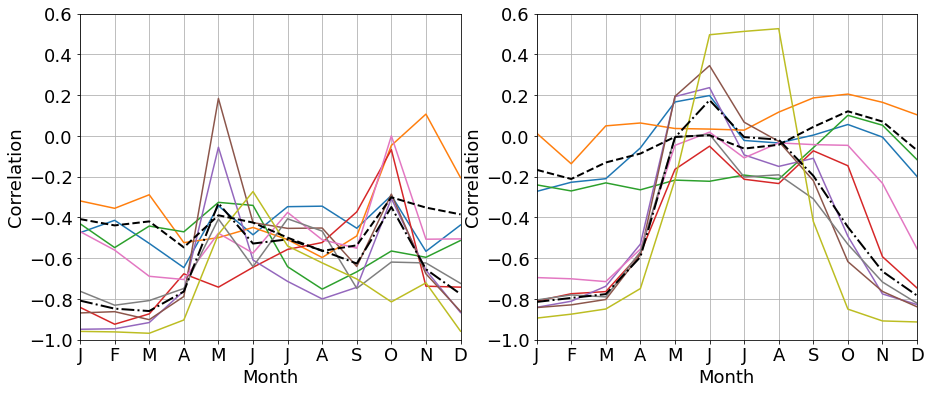

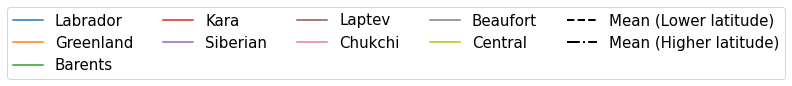

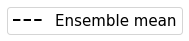

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes = axes.flatten()
# fig.suptitle(
#     f'''{experiment} Correlation between evspsbl and siarea
#     (a) inter-model spatial average 2080-2100 and 
#     (b) ensemble mean across 1980-2100 anom 1980-2010 60-90°N'''
# )

libs.plot.monthly_variability(
    ds_corr_intermodel,
    ax=axes[0],
    fig=fig,
    show_legend=False,
    ylabel='Correlation',
    yrange=(-1, 0.6)
);

libs.plot.monthly_variability(
    ds_corr_ensemble_mean,
    ax=axes[1],
    fig=fig,
    show_legend=False,
    ylabel='Correlation',
    yrange=(-1, 0.6)
);

libs.plot.legend_standalone(
    fig,
    legend_confs=[
        { 'ncol': 5, 'exclude': [] },
        { 'ncol': 6, 'exclude': [] },
    ]
)